<a href="https://colab.research.google.com/github/ixd-ai-hub/Research-Ground/blob/feature%2FCU-865d7mpad-sticker-generation-models/Sticker_Set_Automator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Sticker Set Automator

### Models
- Img2Img Genertor
- Background Removal Models
- Edge Detector

### Steps
- read init character from given dir.
- create sketch image for each image
- design action editor
- save on several seeds for given action on given image & character prompt {write a additional for loop to inter over actions}

# 01. Cloning github repository and importing libraries

### 1.1 Cloning repositories

In [ ]:
! git clone https://github.com/xuebinqin/DIS

%cd ./DIS/IS-Net

!pip install gdown
!pip install kornia

fatal: destination path 'DIS' already exists and is not an empty directory.
/content/DIS/IS-Net
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 1.2 Importing libraries

In [ ]:
import numpy as np
from PIL import Image
import torch
from torch.autograd import Variable
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import gdown
import os
import cv2
import kornia as K


import requests
import matplotlib.pyplot as plt
from io import BytesIO
import glob

# project imports
from data_loader_cache import normalize, im_reader, im_preprocess
from models import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'

from google.colab import drive
drive.mount('/content/gdrive')


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
def get_input_images(root_folder):
  dir = f'/content/gdrive/MyDrive/{root_folder}/Initial Character Folder/*'
  image_paths = glob.glob(dir)
  image_paths.sort()
  return image_paths

def get_prompts(root_folder, document_name):
  dir = f'/content/gdrive/MyDrive/{root_folder}/{document_name}.txt'
  prompts = open(dir, 'r').read().split('\n')
  return prompts

def prompt_modifier(prompt, action):
  prompt = prompt.split(",")
  prompt.insert(1, action)
  output = ", ".join(prompt)
  return output

def save_outputs(images, root_folder, prompt):
  from google.colab import drive
  drive.mount('/content/gdrive')
  char_description = prompt.split(",")
  dir = f'/content/gdrive/MyDrive/{root_folder}/outputs/{char_description[0]}/'
  if not os.path.exists(dir): os.makedirs(dir)
  for i, img in enumerate(images):
    print(dir + char_description[1] + '_' + str(i) + '.png')
    output_path = dir + char_description[1] + '_' + str(i) + '.png'
    img.save(output_path)

In [ ]:
class GOSNormalize(object):
  '''
  Normalize the Image using torch.transforms
  '''
  def __init__(self, mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]):
      self.mean = mean
      self.std = std

  def __call__(self,image):
      image = normalize(image,self.mean,self.std)
      return image

def background_remover(img_path):
  if not os.path.exists("./saved_models"):
    !mkdir ./saved_models
    MODEL_PATH_URL = "https://drive.google.com/uc?id=1KyMpRjewZdyYfxHPYcd-ZbanIXtin0Sn"
    gdown.download(MODEL_PATH_URL, "./saved_models/isnet.pth", use_cookies=False)

  transform =  transforms.Compose([GOSNormalize([0.5,0.5,0.5],[1.0,1.0,1.0])])

  def load_image(im_path, hypar):
    if im_path.startswith("http"):
        im_path = BytesIO(requests.get(im_path).content)

    im = im_reader(im_path)
    print(im.shape)
    im, im_shp = im_preprocess(im, hypar["cache_size"])
    im = torch.divide(im,255.0)
    shape = torch.from_numpy(np.array(im_shp))
    return transform(im).unsqueeze(0), shape.unsqueeze(0) # make a batch of image, shape


  def build_model(hypar,device):
    net = hypar["model"]#GOSNETINC(3,1)

    # convert to half precision
    if(hypar["model_digit"]=="half"):
        net.half()
        for layer in net.modules():
            if isinstance(layer, nn.BatchNorm2d):
                layer.float()

    net.to(device)

    if(hypar["restore_model"]!=""):
        net.load_state_dict(torch.load(hypar["model_path"]+"/"+hypar["restore_model"],map_location=device))
        net.to(device)
    net.eval()
    return net


  def predict(net,  inputs_val, shapes_val, hypar, device):
    '''
    Given an Image, predict the mask
    '''
    net.eval()

    if(hypar["model_digit"]=="full"):
        inputs_val = inputs_val.type(torch.FloatTensor)
    else:
        inputs_val = inputs_val.type(torch.HalfTensor)


    inputs_val_v = Variable(inputs_val, requires_grad=False).to(device) # wrap inputs in Variable

    ds_val = net(inputs_val_v)[0] # list of 6 results

    pred_val = ds_val[0][0,:,:,:] # B x 1 x H x W    # we want the first one which is the most accurate prediction

    ## recover the prediction spatial size to the orignal image size
    pred_val = torch.squeeze(F.upsample(torch.unsqueeze(pred_val,0),(shapes_val[0][0],shapes_val[0][1]),mode='bilinear'))

    ma = torch.max(pred_val)
    mi = torch.min(pred_val)
    pred_val = (pred_val-mi)/(ma-mi) # max = 1

    if device == 'cuda': torch.cuda.empty_cache()
    return (pred_val.detach().cpu().numpy()*255).astype(np.uint8)

  def setting_parameters():
    hypar = {} # paramters for inferencing


    hypar["model_path"] ="./saved_models" ## load trained weights from this path
    hypar["restore_model"] = "isnet.pth" ## name of the to-be-loaded weights
    hypar["interm_sup"] = False ## indicate if activate intermediate feature supervision

    ##  choose floating point accuracy --
    hypar["model_digit"] = "full" ## indicates "half" or "full" accuracy of float number
    hypar["seed"] = 0

    hypar["cache_size"] = [1024, 1024] ## cached input spatial resolution, can be configured into different size

    ## data augmentation parameters ---
    hypar["input_size"] = [1024, 1024] ## mdoel input spatial size, usually use the same value hypar["cache_size"], which means we don't further resize the images
    hypar["crop_size"] = [1024, 1024] ## random crop size from the input, it is usually set as smaller than hypar["cache_size"], e.g., [920,920] for data augmentation

    hypar["model"] = ISNetDIS()

    return hypar

  hypar = setting_parameters()
  net = build_model(hypar, device)

  # image_path = "/content/test_img.png"
  image_path = img_path


  image_tensor, orig_size = load_image(image_path, hypar)
  mask = predict(net,image_tensor,orig_size, hypar, device)

  if image_path.startswith("http"):
    image_np = np.array(Image.open(image_bytes))
  else:
    image_np = np.array(Image.open(image_path))

  binary_mask = (mask > 0).astype(np.uint8)
  masked_image = np.multiply(image_np, binary_mask[..., np.newaxis])

  output_path = "/content/masked_img.png"
  im = Image.fromarray(masked_image)
  im.save(output_path)

  return masked_image


#03. Edge detector

In [ ]:
def edge_detector(masked_img):
  x_bgr: torch.Tensor = K.utils.image_to_tensor(masked_img)
  x_bgr = x_bgr[None,...].float() / 255.
  x_rgb: torch.Tensor = K.color.bgr_to_rgb(x_bgr)
  x_gray = K.color.rgb_to_grayscale(x_rgb)

  x_laplacian: torch.Tensor = K.filters.canny(x_gray)[0]
  edge_img = (1. - x_laplacian.clamp(0., 1.)).numpy()*255.
  edge_img = edge_img[0,0, :, :].astype(np.uint8)

  edge_rgb = np.array([edge_img, edge_img, edge_img])
  edge_rgb = np.transpose(edge_rgb, (1,2,0))

  edge_rgb = Image.fromarray(edge_rgb)
  edge_rgb.save("/content/edge_img.png")

  return edge_rgb

#3. Image generator

In [ ]:
def image_generator(text_prompt, action, init_path = '/content/edge_img.png'):
  from IPython import get_ipython

  # @title <font color="cyan">Generate NFT</font>

  DevMode = True
  Version = "v0.6.11"
  Model = "runwayml/stable-diffusion-v1-5"  #@param ["runwayml/stable-diffusion-v1-5", "stabilityai/stable-diffusion-2-1", "CompVis/stable-diffusion-v1-4", "naclbit/trinart_stable_diffusion_v2", "hakurei/waifu-diffusion", "nitrosocke/Arcane-Diffusion", "nitrosocke/archer-diffusion", "nitrosocke/elden-ring-diffusion", "nitrosocke/spider-verse-diffusion", "nitrosocke/modern-disney-diffusion", "hakurei/waifu-diffusion", "lambdalabs/sd-pokemon-diffusers", "yuk/fuyuko-waifu-diffusion", "AstraliteHeart/pony-diffusion", "nousr/robo-diffusion", "DGSpitzer/Cyberpunk-Anime-Diffusion", "sd-dreambooth-library/herge-style"]

  import importlib, os, shutil
  try:
      importlib.reload(colab)
      importlib.reload(img2img)
  except: pass
  # Clone repo
  if os.path.exists("/content/"):
      # In colab
      if os.path.exists("/content/void-diffusion"):
          shutil.rmtree('/content/void-diffusion')
      os.chdir("/content")
      if DevMode:
        print("Cloning an unstable version -> ", end="")
        get_ipython().system("git clone https://github.com/nipdep/void-diffusion.git &> /dev/null")
      else:
        print("Updating from nipdep/void-diffusion (%s) -> " % Version, end="")
        get_ipython().system("git clone --depth 1 --branch %s https://github.com/nipdep/void-diffusion.git &> /dev/null" % Version)
      print("Done.")
      try: os.chdir("/content/void-diffusion")
      except: print("Couldn't clone the repository. You sure that version exists?")
      print("Installing dependencies -> ", end="")
      !pip install einops torch transformers diffusers accelerate > /dev/null
      print("Done.")
      import colab
      importlib.reload(colab)
      try: colab.init(Model)
      except Exception as e:
        print("Error: ")
        print(e)
        print("\nThings you can try:\n- Just click again\n- Delete and restart the runtime\n- Select a different model")
  else:
      # Not in colab
      if not os.path.basename(os.getcwd()) == "void-diffusion":
        if DevMode:
          print("Cloning an unstable version -> ", end="")
          !git clone https://github.com/nipdep/void-diffusion.git &> /dev/null
        else:
          print("Updating from nipdep/void-diffusion (%s) -> " % Version, end="")
          !git clone --depth 1 --branch v0.6 https://github.com/nipdep/void-diffusion.git &> /dev/null
        print("Done.")
        os.chdir("void-diffusion")
      !git pull >nul
      print("Installing dependencies -> ", end="")
      !pip install einops torch transformers diffusers accelerate >nul
      print("Done.")
      import colab
      try: colab.init(Model)
      except Exception as e:
        print("Error: ")
        print(e)
        print("\nThings you can try:\n- Just click again\n- Delete and restart the runtime\n- Select a different model")


  try:
    import colab, os, shutil, datetime
    from IPython import display
    from IPython.display import HTML
    if colab.ready: # needed to trigger an exception
      #@title <font color="orange">Settings & Google Drive</font>
      #@markdown General
      Seed = 5 #@param {type:"number"}
      if Seed == None:
          Seed = 0
      Width = "512" #@param [256, 512, 1024, 2048]
      Height = "512" #@param [256, 512, 1024, 2048]
      Scheduler = "K-EULER" #@param ["Default", "K-EULER", "DDIM", "K-LMS", "DPMSolver-Multistep"]
      #@markdown Google Drive settings
      SaveToGoogleDrive = False
      ShouldSaveToGoogleDrive = True #@param {type:"boolean"}
      SaveDiffusionSettings = False #@param {type:"boolean"}
      Directory = "AI-Gen"
      colab.settings['Seed'] = int(Seed)
      colab.settings['Width'] = int(Width)
      colab.settings['Height'] = int(Height)
      colab.settings['Scheduler'] = Scheduler
      colab.save_directory = Directory
      colab.save_settings = SaveDiffusionSettings
      try:
        # GDrive
        if SaveToGoogleDrive:
          from google.colab import drive
          drive.mount('/content/gdrive', force_remount=True)
          SaveToGoogleDrive = True
        # Log
        display.display(HTML("<strong><span style='color: green'>Last saved at %s</span></strong>" % datetime.datetime.now().strftime("%H:%M")))
      except Exception as e: print(e)
  except: print("Couldn't save settings! No model was selected.")


  try:
    import colab, img2img, importlib
    if colab.ready:
      importlib.reload(img2img)
      #@markdown <b>Prompt & Generator settings.</b>
      InitialImageURL = init_path
      Local = True
      prompt = prompt_modifier(text_prompt, action)
      #manager = ", centered, full body,full face slim,standing with brown boots,show every detials of the body"
      Style = ", low poly, isometric art, 3d art, high detail, artstation, concept art, behance, ray tracing, smooth, sharp focus, ethereal lighting"
      Prompt = prompt+ Style
      NegativePrompt = "blurry, abstract, disfigured, deformed, cartoon, animated, toy, figure, framed, 3d, hands, nude, cartoon, 3d, disfigured, bad art, deformed, poorly drawn, extra limbs, close up, b&w, weird colors, blurry, watermark high contrast, photo filters, closed eyes, black and white photography, ginger, multiple people, collage, statues, group photo, split screen, bright red hair, (ugly eyes, deformed iris, deformed pupils, fused lips and teeth:1.2), (un-detailed skin, cgi, render, sketch, cartoon, drawing, anime:1.2), text, close up, cropped, out of frame, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck, blur haze" #param {type:"string"}
      GuidanceScale = 30.4 #@param {type:"slider", min:1, max:50, step:0.1}
      Strength = 0.83 #@param {type:"slider", min:0, max:1, step:0.01}
      Steps = 98 #@param {type:"slider", min:1, max:500, step:1}
      Image_Count = 4 #@param {type:"slider", min:1, max:100, step:1}
      PostParallelism = 2 #@param {type:"slider", min:1, max:4, step:1}
      PostReplaceResultView = False #@param {type:"boolean"}
      Preview = False #@param {type:"boolean"}
      colab.settings["Prompt"] = Prompt
      colab.settings["NegativePrompt"] = NegativePrompt
      colab.settings["InitialImageURL"] = InitialImageURL
      colab.settings["Local"] = Local
      colab.settings['GuidanceScale'] = float(GuidanceScale)
      colab.settings["Steps"] = Steps
      colab.settings["Strength"] = Strength
      colab.settings["Iterations"] = Image_Count
      try:
        output = img2img.process(ShouldSave=SaveToGoogleDrive, ShouldPreview=Preview)
      except Exception as e: print(e)
  except Exception as e: print(e) #: print("No model was selected.")

  if ShouldSaveToGoogleDrive:
    save_outputs(output, 'AI-Gen', Prompt)



'Iterations: 0/4'

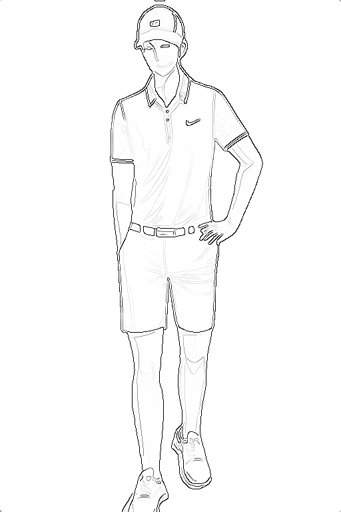

'Seed: 5'

'Execution time: 9.60s'

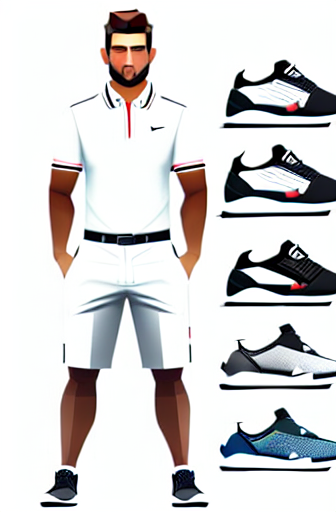

  0%|          | 0/81 [00:00<?, ?it/s]

'Iterations: 4/4'

'Seed: 6'

'Execution time: 9.64s'

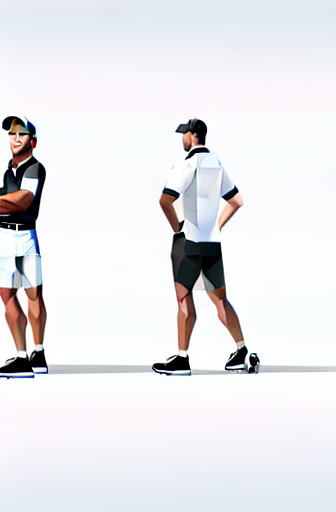

  0%|          | 0/81 [00:00<?, ?it/s]

'Seed: 7'

'Execution time: 9.80s'

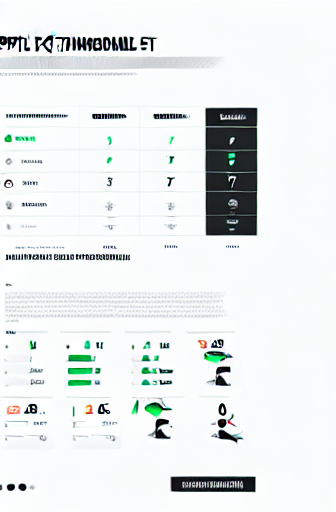

  0%|          | 0/81 [00:00<?, ?it/s]

'Seed: 8'

'Execution time: 9.81s'

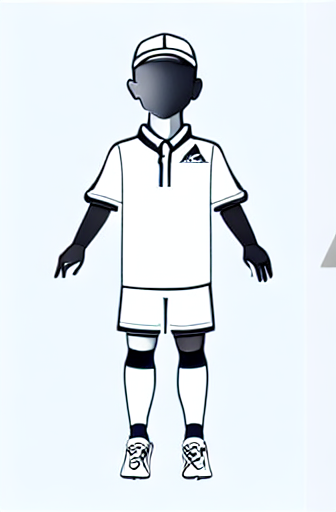

  0%|          | 0/81 [00:00<?, ?it/s]

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/AI-Gen/outputs/A sporty golf player wearing a black polo shirt and matching shorts/ sitting_0.png
/content/gdrive/MyDrive/AI-Gen/outputs/A sporty golf player wearing a black polo shirt and matching shorts/ sitting_1.png
/content/gdrive/MyDrive/AI-Gen/outputs/A sporty golf player wearing a black polo shirt and matching shorts/ sitting_2.png
/content/gdrive/MyDrive/AI-Gen/outputs/A sporty golf player wearing a black polo shirt and matching shorts/ sitting_3.png


In [ ]:
root_folder = 'AI-Gen'#@param {type:"string"}
prompt_document_name = 'image2prompt' #@param {type:"string"}
image_paths = get_input_images(root_folder)
image_prompts = get_prompts(root_folder, prompt_document_name)
action_list = ['walking', 'sitting']
for i, image_path in enumerate(image_paths):
   masked_image = background_remover(image_path)
   edged_image = edge_detector(masked_image)
   for action in action_list:
     image_generator(image_prompts[i], action, init_path = '/content/edge_img.png')
